In [1]:
# HF token prelude – load from common macOS locations and set env for HF
import os, pathlib

def load_hf_token():
    candidates = [
        pathlib.Path("~/.cache/huggingface/token").expanduser(),
        pathlib.Path("~/Library/Application Support/huggingface/token").expanduser(),
        pathlib.Path("~/.huggingface/token").expanduser(),
    ]
    for p in candidates:
        if p.exists():
            tok = p.read_text().strip()
            if tok.startswith("hf_"):
                return tok
    # Fallback to env if user already exported it
    return os.environ.get("HF_TOKEN")

HF_TOKEN = load_hf_token()
if HF_TOKEN:
    os.environ["HF_TOKEN"] = HF_TOKEN  # make visible to transformers/hub
    print("✅ HF token loaded (length:", len(HF_TOKEN), ")")
else:
    print("⚠️ No HF token found. Set os.environ['HF_TOKEN'] = 'hf_...'.")

✅ HF token loaded (length: 37 )


In [2]:
# --- SRB import prelude: point to the correct repo and reload the module ---

import sys, os, importlib, inspect

# 1) Point to the repo that actually contains your updated metrics.py
repo_root = "/Users/joeystafford/repos/semantic-resonance-budget-falsification"

# Ensure it’s at the *front* of sys.path so it wins over any other srb installs/paths
if repo_root in sys.path:
    sys.path.remove(repo_root)
sys.path.insert(0, repo_root)

# 2) Purge any previously loaded 'srb' to avoid stale modules
for name in list(sys.modules.keys()):
    if name == "srb" or name.startswith("srb."):
        del sys.modules[name]

# 3) Import and reload to be extra sure we’re using the right file
import srb.metrics as sm
print("Using metrics module at:", sm.__file__)
importlib.reload(sm)

# 4) Sanity: list the exported helpers you need
wanted = ["chunk_text_windows", "pairwise", "cosine_text_similarity", "ncd_similarity",
          "levenshtein_similarity_tokens", "coherence_composite", "repetition_ratio"]
available = [n for n, o in sm.__dict__.items() if callable(o) and n in wanted]
print("Available functions:", available)

# 5) Finally import the fresh symbols into the notebook namespace
from srb.metrics import (
    chunk_text_windows, pairwise,
    cosine_text_similarity, ncd_similarity,
    levenshtein_similarity_tokens, coherence_composite, repetition_ratio
)

Using metrics module at: /Users/joeystafford/repos/semantic-resonance-budget-falsification/srb/metrics.py
Available functions: ['cosine_text_similarity', 'ncd_similarity', 'levenshtein_similarity_tokens', 'chunk_text_windows', 'pairwise', 'repetition_ratio', 'coherence_composite']


→ Trying model: meta-llama/Llama-3-8B-Instruct
✗ Could not load meta-llama/Llama-3-8B-Instruct: meta-llama/Llama-3-8B-Instruct is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `hf auth login` or by passing `token=<your_token>`
→ Trying model: mistralai/Mistral-7B-Instruct-v0.3
✗ Could not load mistralai/Mistral-7B-Instruct-v0.3: 
 requires the protobuf library but it was not found in your environment. Check out the instructions on the
installation page of its repo: https://github.com/protocolbuffers/protobuf/tree/master/python#installation and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.

→ Trying model: Qwen/Qwen2.5-7B-Instruct


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Loaded: Qwen/Qwen2.5-7B-Instruct


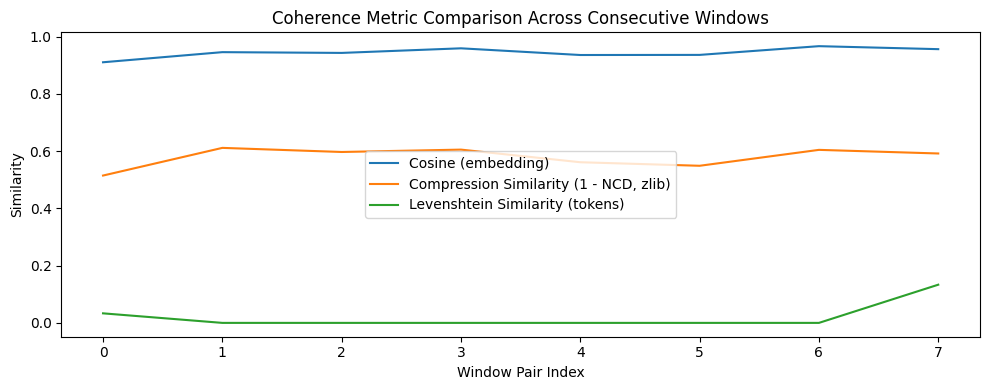

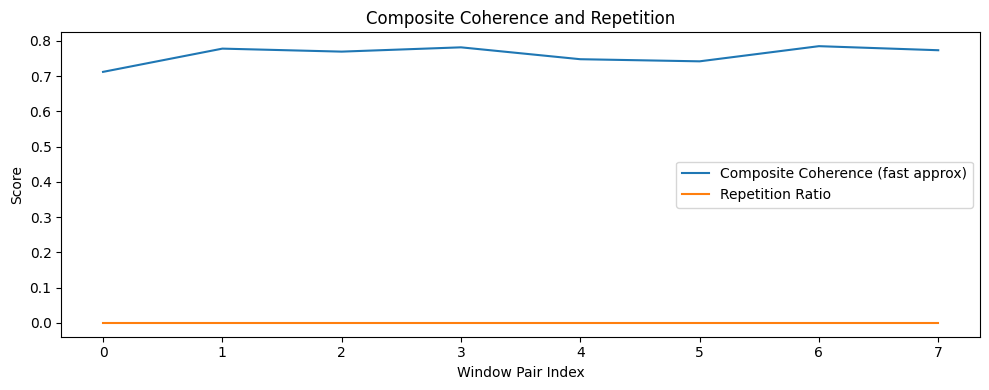

=== Pearson Correlations ===
cos  vs comp  :  0.947
cos  vs ncd   :  0.882
cos  vs lev   :  0.084
comp vs ncd   :  0.986
comp vs lev   : -0.001
ncd  vs lev   : -0.044
rep  vs cos   :  nan
rep  vs comp  :  nan
rep  vs ncd   :  nan
rep  vs lev   :  nan

Summary:
- Windows: 9 (size=30, step=15)
- Mean cosine:     0.944
- Mean 1-NCD(gzip):0.579
- Mean Lev(tokens):0.021
- Mean composite:  0.761
- Mean repetition: 0.000

--- Generated Text ---

Explain quantum entanglement to a curious high-school student using analogies and avoid repeating phrases. Quantum entanglement is like a pair of magic dice that are connected in an invisible way, even if they're far apart. Imagine you have two dice in different cities, and when you roll them, they always show the same number, but you can't predict what number will appear until you actually roll them. No matter how far apart these dice are, their outcomes remain linked. If you roll one die and it shows a six, the other one instantly shows a six too, w

In [3]:
# --- SRB Coherence Metric Comparison (fast batch version, token-aware) ---

# 1) Imports
import os, numpy as np, torch, matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer

from srb.metrics import (
    chunk_text_windows, pairwise,
    ncd_similarity, levenshtein_similarity_tokens,
    coherence_composite, repetition_ratio
)

# 2) Token-aware model loader with public fallbacks
HF_TOKEN = os.environ.get("HF_TOKEN")
token_kw = {"token": HF_TOKEN} if HF_TOKEN else {}

PREFERRED_MODELS = [
    "meta-llama/Llama-3-8B-Instruct",      # gated
    "mistralai/Mistral-7B-Instruct-v0.3",  # public
    "Qwen/Qwen2.5-7B-Instruct",            # public
    "distilGPT2",                          # tiny fallback
]

def try_load(model_name: str):
    print(f"→ Trying model: {model_name}")
    tok = AutoTokenizer.from_pretrained(model_name, **token_kw)
    mdl = AutoModelForCausalLM.from_pretrained(
        model_name, device_map="auto", torch_dtype="auto", **token_kw
    )
    # pad token sanity (Qwen often needs this)
    if tok.pad_token is None:
        tok.pad_token = tok.eos_token
    if getattr(mdl.config, "pad_token_id", None) is None:
        mdl.config.pad_token_id = tok.pad_token_id
    mdl.eval()
    return tok, mdl

tokenizer = model = None
last_err = None
for name in PREFERRED_MODELS:
    try:
        tokenizer, model = try_load(name)
        model_name = name
        print(f"✅ Loaded: {name}")
        break
    except Exception as e:
        last_err = e
        print(f"✗ Could not load {name}: {e}")

if model is None:
    raise RuntimeError("Failed to load any model. Ensure HF_TOKEN is set & license accepted.\n"
                       f"Last error: {last_err}")

# 3) Batch embedding (FAST): mean-pool last hidden states for a list of texts
def batch_embed(texts):
    """Fast mean-pooled embeddings for a list of texts (handles bfloat16 on MPS)."""
    with torch.no_grad():
        toks = tokenizer(
            texts, return_tensors="pt", padding=True, truncation=True
        ).to(model.device)
        out = model(**toks, output_hidden_states=True)
        last = out.hidden_states[-1]                 # [B, S, H]
        # Cast from bfloat16 -> float32 so NumPy can handle it
        last = last.to(torch.float32)
        vecs = last.mean(dim=1).detach().cpu().numpy()  # [B, H]
        return vecs

def cosine_vec(a, b):
    denom = (np.linalg.norm(a) * np.linalg.norm(b)) + 1e-12
    return float(np.dot(a, b) / denom)

def embed_fn(text: str) -> np.ndarray:
    with torch.no_grad():
        toks = tokenizer(text, return_tensors="pt", truncation=True).to(model.device)
        out = model(**toks, output_hidden_states=True)
        last = out.hidden_states[-1].to(torch.float32)   # cast here
        vec = last.squeeze(0).mean(dim=0).detach().cpu().numpy()
        return vec

# 4) Generate text
prompt = "Explain quantum entanglement to a curious high-school student using analogies and avoid repeating phrases."
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
with torch.no_grad():
    gen = model.generate(
        **inputs,
        max_new_tokens=160,        # slightly lower for speed
        do_sample=True,
        temperature=0.9,
        top_p=0.95,
        return_dict_in_generate=True
    )
generated_text = tokenizer.decode(gen.sequences[0], skip_special_tokens=True)

# 5) Windowing (fewer windows = faster postprocessing)
WINDOW_WORDS = 30
STEP_WORDS   = 15
windows = chunk_text_windows(generated_text, window_words=WINDOW_WORDS, step_words=STEP_WORDS)

if len(windows) < 2:
    print("Not enough text for window comparisons. Increase max_new_tokens or reduce window size.")
else:
    # 6) Precompute embeddings for ALL windows in one pass
    window_embs = batch_embed(windows)

    # 7) Compute metrics across consecutive windows
    cos_vals, ncd_vals, lev_vals, comp_vals, rep_vals = [], [], [], [], []

    # Use faster compression for NCD; lzma is slow. You can switch back later.
    compression_method = "gzip"

    for i in range(len(windows) - 1):
        prev_w, curr_w = windows[i], windows[i+1]
        # cosine via precomputed vectors (FAST)
        cos_vals.append(cosine_vec(window_embs[i], window_embs[i+1]))
        # ncd (1 - NCD)
        ncd_vals.append(ncd_similarity(prev_w, curr_w, method=compression_method))
        # token-level Levenshtein
        lev_vals.append(levenshtein_similarity_tokens(prev_w, curr_w))
        # composite (still calls embed_fn normally, but we can approximate with our vectors):
        # quick composite using the cosine we already computed to avoid a second forward pass
        # scale: blend cosine + compression with repetition penalty, like in coherence_composite
        rep = 0.5 * (repetition_ratio(prev_w) + repetition_ratio(curr_w))
        base = 0.5 * cos_vals[-1] + 0.5 * ncd_vals[-1]
        comp = base * (1.0 - 0.3 * rep)  # weights/penalty aligned with earlier defaults
        comp_vals.append(comp)
        rep_vals.append(repetition_ratio(curr_w))

    cos_vals = np.array(cos_vals); ncd_vals = np.array(ncd_vals)
    lev_vals = np.array(lev_vals); comp_vals= np.array(comp_vals)
    rep_vals = np.array(rep_vals)

    # 8) Plots
    plt.figure(figsize=(10, 4))
    plt.plot(cos_vals, label="Cosine (embedding)")
    plt.plot(ncd_vals, label="Compression Similarity (1 - NCD, zlib)")
    plt.plot(lev_vals, label="Levenshtein Similarity (tokens)")
    plt.title("Coherence Metric Comparison Across Consecutive Windows")
    plt.xlabel("Window Pair Index"); plt.ylabel("Similarity")
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(comp_vals, label="Composite Coherence (fast approx)")
    plt.plot(rep_vals, label="Repetition Ratio")
    plt.title("Composite Coherence and Repetition")
    plt.xlabel("Window Pair Index"); plt.ylabel("Score")
    plt.legend(); plt.tight_layout(); plt.show()

    # 9) Correlations
    def safe_corr(a, b):
        if len(a) < 2 or np.all(a == a[0]) or np.all(b == b[0]):
            return np.nan
        return float(np.corrcoef(a, b)[0, 1])

    print("=== Pearson Correlations ===")
    print(f"cos  vs comp  : {safe_corr(cos_vals, comp_vals): .3f}")
    print(f"cos  vs ncd   : {safe_corr(cos_vals, ncd_vals): .3f}")
    print(f"cos  vs lev   : {safe_corr(cos_vals, lev_vals): .3f}")
    print(f"comp vs ncd   : {safe_corr(comp_vals, ncd_vals): .3f}")
    print(f"comp vs lev   : {safe_corr(comp_vals, lev_vals): .3f}")
    print(f"ncd  vs lev   : {safe_corr(ncd_vals, lev_vals): .3f}")
    print(f"rep  vs cos   : {safe_corr(rep_vals, cos_vals): .3f}")
    print(f"rep  vs comp  : {safe_corr(rep_vals, comp_vals): .3f}")
    print(f"rep  vs ncd   : {safe_corr(rep_vals, ncd_vals): .3f}")
    print(f"rep  vs lev   : {safe_corr(rep_vals, lev_vals): .3f}")

    # 10) Summary
    print("\nSummary:")
    print(f"- Windows: {len(windows)} (size={WINDOW_WORDS}, step={STEP_WORDS})")
    print(f"- Mean cosine:     {cos_vals.mean():.3f}")
    print(f"- Mean 1-NCD(gzip):{ncd_vals.mean():.3f}")
    print(f"- Mean Lev(tokens):{lev_vals.mean():.3f}")
    print(f"- Mean composite:  {comp_vals.mean():.3f}")
    print(f"- Mean repetition: {rep_vals.mean():.3f}")

print("\n--- Generated Text ---\n")
print(generated_text)


========== [Repetition] ==========
Prompt: Repeat the following sentence exactly, thirty times in a row, with periods between each: 'Order emerges from careful attention.'


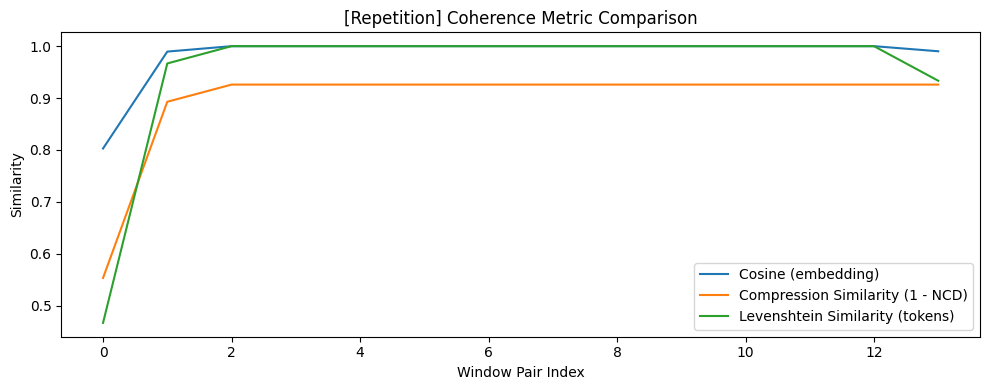

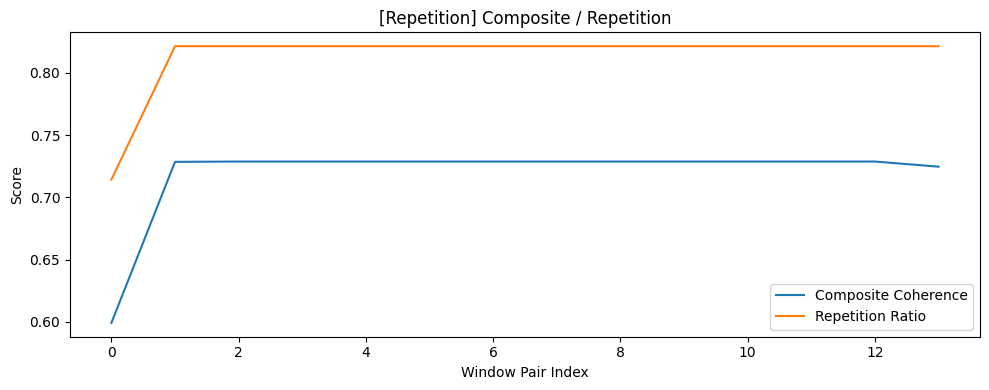

=== Pearson Correlations ===
cos  vs comp  :  0.999
cos  vs ncd   :  0.998
cos  vs lev   :  0.997
comp vs ncd   :  0.995
comp vs lev   :  0.994
ncd  vs lev   :  0.992
rep  vs cos   :  0.998
rep  vs comp  :  1.000
rep  vs ncd   :  0.996
rep  vs lev   :  0.991

Summary:
- Windows: 15 (size=30, step=15)
- Mean cosine:     0.984
- Mean 1-NCD:      0.897
- Mean Lev(tokens):0.955
- Mean composite:  0.719
- Mean repetition: 0.814

========== [Creative/Bilingual] ==========
Prompt: Write a short poem alternating lines in English and Japanese (romaji ok). Avoid repeating phrases and favor metaphor.


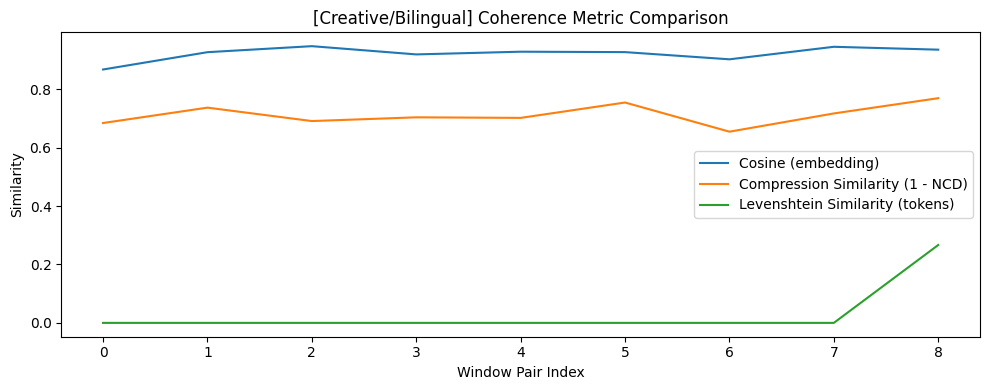

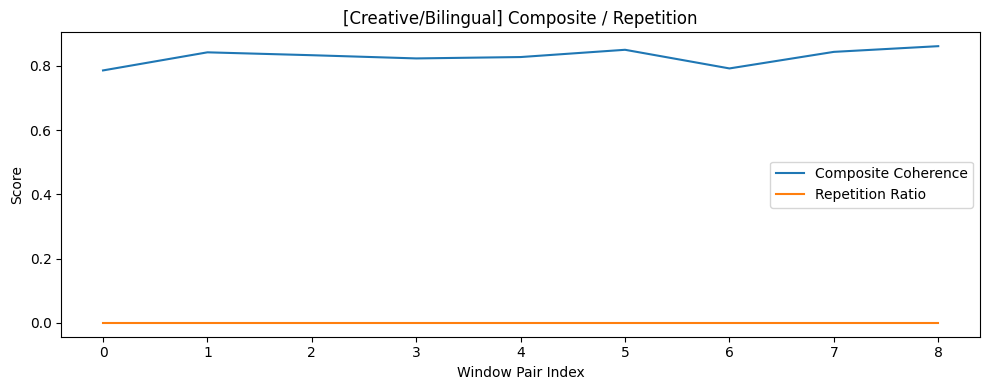

=== Pearson Correlations ===
cos  vs comp  :  0.829
cos  vs ncd   :  0.463
cos  vs lev   :  0.202
comp vs ncd   :  0.880
comp vs lev   :  0.481
ncd  vs lev   :  0.590
rep  vs cos   :  nan
rep  vs comp  :  nan
rep  vs ncd   :  nan
rep  vs lev   :  nan

Summary:
- Windows: 10 (size=30, step=15)
- Mean cosine:     0.922
- Mean 1-NCD:      0.713
- Mean Lev(tokens):0.030
- Mean composite:  0.829
- Mean repetition: 0.000

========== [Long-form Reasoning] ==========
Prompt: Answer the following three questions in sequence with clear transitions: 1) What is quantum entanglement? 2) Why does it not enable faster-than-light communication? 3) Give a real-world analogy that avoids repetition.


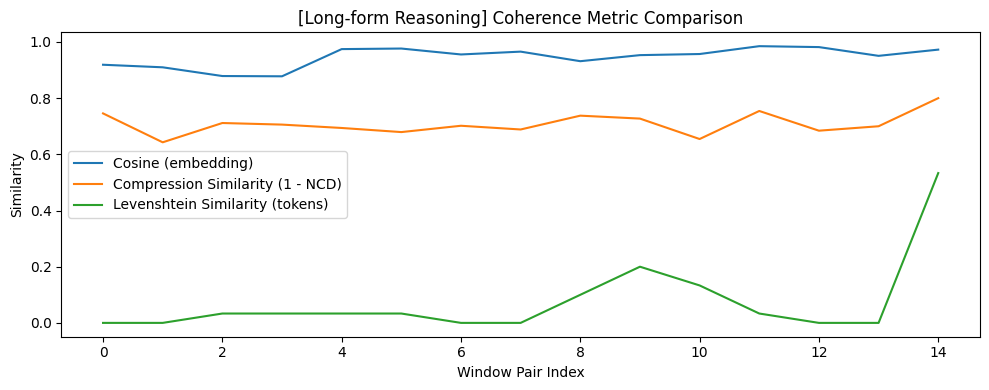

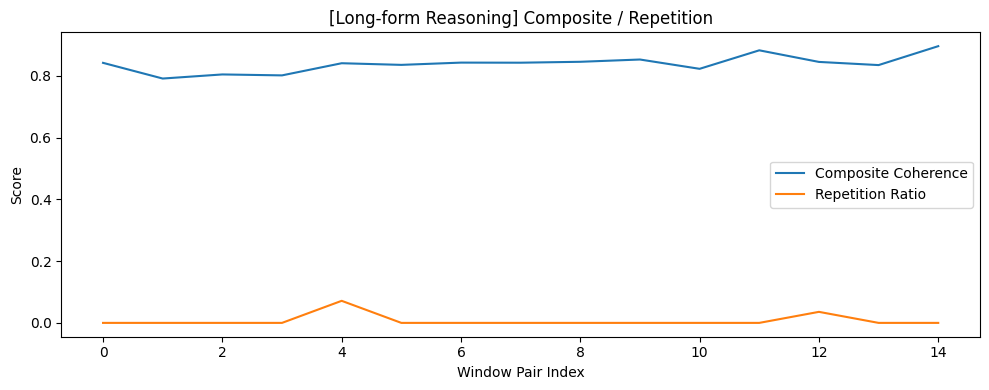

=== Pearson Correlations ===
cos  vs comp  :  0.723
cos  vs ncd   :  0.102
cos  vs lev   :  0.211
comp vs ncd   :  0.754
comp vs lev   :  0.576
ncd  vs lev   :  0.618
rep  vs cos   :  0.337
rep  vs comp  :  0.049
rep  vs ncd   : -0.170
rep  vs lev   : -0.146

Summary:
- Windows: 16 (size=30, step=15)
- Mean cosine:     0.946
- Mean 1-NCD:      0.709
- Mean Lev(tokens):0.076
- Mean composite:  0.839
- Mean repetition: 0.007

Completed all prompt evaluations.


In [4]:
# --- SRB Coherence Metric Comparison across 3 prompt behaviors ---

import numpy as np
import matplotlib.pyplot as plt
from srb.metrics import (
    chunk_text_windows, pairwise,
    cosine_text_similarity, ncd_similarity, levenshtein_similarity_tokens,
    coherence_composite, repetition_ratio
)
import torch

def evaluate_prompt(prompt: str, label: str,
                    max_new_tokens: int = 220,
                    temperature: float = 0.9,
                    window_words: int = 30,
                    step_words:   int = 15):
    """Generate text, window it, compute metrics, plot curves, and print stats."""
    print(f"\n========== [{label}] ==========")
    print("Prompt:", prompt)

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        gen = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=temperature,
            top_p=0.95,
            return_dict_in_generate=True
        )
    text = tokenizer.decode(gen.sequences[0], skip_special_tokens=True)

    windows = chunk_text_windows(text, window_words=window_words, step_words=step_words)
    if len(windows) < 2:
        print("Not enough text for window comparisons. Try increasing max_new_tokens or reducing window size.")
        print("\n--- Generated Text ---\n", text)
        return None

    cos_vals, ncd_vals, lev_vals, comp_vals, rep_vals = [], [], [], [], []
    for prev_w, curr_w in pairwise(windows):
        cos_vals.append(cosine_text_similarity(prev_w, curr_w, embed_fn))
        ncd_vals.append(ncd_similarity(prev_w, curr_w))
        lev_vals.append(levenshtein_similarity_tokens(prev_w, curr_w))
        comp_vals.append(coherence_composite(prev_w, curr_w, embed_fn))
        rep_vals.append(repetition_ratio(curr_w))

    cos_vals = np.array(cos_vals, dtype=float)
    ncd_vals = np.array(ncd_vals, dtype=float)
    lev_vals = np.array(lev_vals, dtype=float)
    comp_vals= np.array(comp_vals, dtype=float)
    rep_vals = np.array(rep_vals, dtype=float)

    # Plot 1: core metrics
    plt.figure(figsize=(10, 4))
    plt.plot(cos_vals, label="Cosine (embedding)")
    plt.plot(ncd_vals, label="Compression Similarity (1 - NCD)")
    plt.plot(lev_vals, label="Levenshtein Similarity (tokens)")
    plt.title(f"[{label}] Coherence Metric Comparison")
    plt.xlabel("Window Pair Index")
    plt.ylabel("Similarity")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot 2: composite + repetition
    plt.figure(figsize=(10, 4))
    plt.plot(comp_vals, label="Composite Coherence")
    plt.plot(rep_vals, label="Repetition Ratio")
    plt.title(f"[{label}] Composite / Repetition")
    plt.xlabel("Window Pair Index")
    plt.ylabel("Score")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Correlations
    def safe_corr(a, b):
        if len(a) < 2 or np.all(a == a[0]) or np.all(b == b[0]):
            return np.nan
        return float(np.corrcoef(a, b)[0, 1])

    print("=== Pearson Correlations ===")
    print(f"cos  vs comp  : {safe_corr(cos_vals, comp_vals): .3f}")
    print(f"cos  vs ncd   : {safe_corr(cos_vals, ncd_vals): .3f}")
    print(f"cos  vs lev   : {safe_corr(cos_vals, lev_vals): .3f}")
    print(f"comp vs ncd   : {safe_corr(comp_vals, ncd_vals): .3f}")
    print(f"comp vs lev   : {safe_corr(comp_vals, lev_vals): .3f}")
    print(f"ncd  vs lev   : {safe_corr(ncd_vals, lev_vals): .3f}")
    print(f"rep  vs cos   : {safe_corr(rep_vals, cos_vals): .3f}")
    print(f"rep  vs comp  : {safe_corr(rep_vals, comp_vals): .3f}")
    print(f"rep  vs ncd   : {safe_corr(rep_vals, ncd_vals): .3f}")
    print(f"rep  vs lev   : {safe_corr(rep_vals, lev_vals): .3f}")

    # Summary
    print("\nSummary:")
    print(f"- Windows: {len(windows)} (size={window_words}, step={step_words})")
    print(f"- Mean cosine:     {cos_vals.mean():.3f}")
    print(f"- Mean 1-NCD:      {ncd_vals.mean():.3f}")
    print(f"- Mean Lev(tokens):{lev_vals.mean():.3f}")
    print(f"- Mean composite:  {comp_vals.mean():.3f}")
    print(f"- Mean repetition: {rep_vals.mean():.3f}")

    # Return for optional downstream aggregation
    return {
        "label": label,
        "text": text,
        "cos": cos_vals, "ncd": ncd_vals, "lev": lev_vals, "comp": comp_vals, "rep": rep_vals
    }

# --- Run three behavior regimes ---

prompts = [
    ("Repetition", 
     "Repeat the following sentence exactly, thirty times in a row, with periods between each: "
     "'Order emerges from careful attention.'"),
    ("Creative/Bilingual", 
     "Write a short poem alternating lines in English and Japanese (romaji ok). "
     "Avoid repeating phrases and favor metaphor."),
    ("Long-form Reasoning", 
     "Answer the following three questions in sequence with clear transitions: "
     "1) What is quantum entanglement? "
     "2) Why does it not enable faster-than-light communication? "
     "3) Give a real-world analogy that avoids repetition.")
]

results = []
for label, prompt in prompts:
    res = evaluate_prompt(prompt, label,
                          max_new_tokens=260,
                          temperature=0.9,
                          window_words=30,
                          step_words=15)
    if res is not None:
        results.append(res)

print("\nCompleted all prompt evaluations.")

In [5]:
# --- Aggregated correlations across prompts (with partials controlling for repetition) ---

import numpy as np
import pandas as pd

def safe_corr(a, b):
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    if len(a) < 2 or np.allclose(a, a[0]) or np.allclose(b, b[0]):
        return np.nan
    return float(np.corrcoef(a, b)[0, 1])

def residualize(y, z):
    """
    Remove linear effect of z from y: y_res = y - (alpha + beta*z).
    Adds a bias term for intercept.
    """
    y = np.asarray(y, dtype=float)
    z = np.asarray(z, dtype=float)
    if len(y) != len(z) or len(y) < 2 or np.allclose(z, z[0]):
        return y  # fallback
    X = np.column_stack([np.ones_like(z), z])
    # Least squares fit
    beta, *_ = np.linalg.lstsq(X, y, rcond=None)
    y_hat = X @ beta
    return y - y_hat

def corr_row(label, cos, ncd, lev, comp, rep):
    # Raw Pearson
    row = {
        "prompt": label,
        "r(cos,comp)": safe_corr(cos, comp),
        "r(cos,ncd)":  safe_corr(cos, ncd),
        "r(cos,lev)":  safe_corr(cos, lev),
        "r(comp,ncd)": safe_corr(comp, ncd),
        "r(comp,lev)": safe_corr(comp, lev),
        "r(ncd,lev)":  safe_corr(ncd, lev),
        "r(rep,cos)":  safe_corr(rep, cos),
        "r(rep,comp)": safe_corr(rep, comp),
        "r(rep,ncd)":  safe_corr(rep, ncd),
        "r(rep,lev)":  safe_corr(rep, lev),
        "mean_cos":    np.nanmean(cos),
        "mean_comp":   np.nanmean(comp),
        "mean_ncd":    np.nanmean(ncd),
        "mean_lev":    np.nanmean(lev),
        "mean_rep":    np.nanmean(rep),
        "n_pairs":     len(cos),
    }

    # Partial correlations controlling for repetition (rep)
    cos_res  = residualize(cos, rep)
    comp_res = residualize(comp, rep)
    ncd_res  = residualize(ncd, rep)
    lev_res  = residualize(lev, rep)

    row.update({
        "partial r(cos,comp)|rep": safe_corr(cos_res, comp_res),
        "partial r(cos,ncd)|rep":  safe_corr(cos_res, ncd_res),
        "partial r(cos,lev)|rep":  safe_corr(cos_res, lev_res),
        "partial r(comp,ncd)|rep": safe_corr(comp_res, ncd_res),
        "partial r(comp,lev)|rep": safe_corr(comp_res, lev_res),
        "partial r(ncd,lev)|rep":  safe_corr(ncd_res, lev_res),
    })
    return row

# Build table per prompt
rows = []
for res in results:
    rows.append(
        corr_row(
            res["label"],
            res["cos"], res["ncd"], res["lev"], res["comp"], res["rep"]
        )
    )

df = pd.DataFrame(rows)

# Add an overall row (concatenate all pairs from all prompts)
all_cos  = np.concatenate([r["cos"] for r in results if len(r["cos"]) > 0], axis=0)
all_ncd  = np.concatenate([r["ncd"] for r in results if len(r["ncd"]) > 0], axis=0)
all_lev  = np.concatenate([r["lev"] for r in results if len(r["lev"]) > 0], axis=0)
all_comp = np.concatenate([r["comp"] for r in results if len(r["comp"]) > 0], axis=0)
all_rep  = np.concatenate([r["rep"] for r in results if len(r["rep"]) > 0], axis=0)

overall = corr_row("ALL", all_cos, all_ncd, all_lev, all_comp, all_rep)
df = pd.concat([df, pd.DataFrame([overall])], ignore_index=True)

# Display a compact view
cols_order = [
    "prompt", "n_pairs",
    "r(cos,comp)", "r(cos,ncd)", "r(cos,lev)",
    "r(rep,cos)", "r(rep,comp)",
    "partial r(cos,comp)|rep", "partial r(cos,ncd)|rep", "partial r(cos,lev)|rep",
    "mean_cos", "mean_comp", "mean_ncd", "mean_lev", "mean_rep"
]
display(df[cols_order].round(3))

print("\nInterpretation tips:")
print("- If r(rep,cos) is strongly positive but partial r(cos,comp)|rep stays moderate/strong, cosine inflation from repetition is being corrected by the composite.")
print("- If r(cos,ncd) and r(cos,lev) drop a lot after partialling out rep, cosine was overvaluing loops.")
print("- In the Creative/Bilingual prompt, expect lower raw r(cos,*) but healthier partials if the text is coherent without repetition.")

,prompt,n_pairs,"r(cos,comp)","r(cos,ncd)","r(cos,lev)","r(rep,cos)","r(rep,comp)","partial r(cos,comp)|rep","partial r(cos,ncd)|rep","partial r(cos,lev)|rep",mean_cos,mean_comp,mean_ncd,mean_lev,mean_rep
0,Repetition,14,0.999,0.998,0.997,0.998,1.000,0.695,0.702,0.928,0.984,0.719,0.897,0.955,0.814
1,Creative/Bilingual,9,0.829,0.463,0.202,NaN,NaN,0.829,0.463,0.202,0.922,0.829,0.713,0.030,0.000
2,Long-form Reasoning,15,0.723,0.102,0.211,0.337,0.049,0.751,0.172,0.280,0.946,0.839,0.709,0.076,0.007
3,ALL,38,-0.089,0.772,0.628,0.529,-0.872,0.898,0.703,0.530,0.955,0.792,0.779,0.389,0.303



Interpretation tips:
- If r(rep,cos) is strongly positive but partial r(cos,comp)|rep stays moderate/strong, cosine inflation from repetition is being corrected by the composite.
- If r(cos,ncd) and r(cos,lev) drop a lot after partialling out rep, cosine was overvaluing loops.
- In the Creative/Bilingual prompt, expect lower raw r(cos,*) but healthier partials if the text is coherent without repetition.


In [7]:
# --- Export SRB Experiment Results (Cell 4) ---

import pandas as pd
import numpy as np
import os, json, time

timestamp = time.strftime("%Y%m%d_%H%M%S")
exp_dir = f"srb_results/{timestamp}"
os.makedirs(exp_dir, exist_ok=True)

print(f"📁 Saving results to: {exp_dir}")

# --- Save generated text + metric curves ---
for res in results:
    label = res["label"].replace(" ", "_").lower()
    subdir = f"{exp_dir}/{label}"
    os.makedirs(subdir, exist_ok=True)

    # Save generated text
    with open(f"{subdir}/generated.txt", "w", encoding="utf-8") as f:
        f.write(res["text"])

    # Save metric curves
    df_curves = pd.DataFrame({
        "cosine": res["cos"],
        "compression_sim": res["ncd"],
        "levenshtein_tok": res["lev"],
        "composite": res["comp"],
        "repetition": res["rep"]
    })
    df_curves.to_csv(f"{subdir}/curves.csv", index=False)

# --- Save summary table (all prompts) ---
df.to_csv(f"{exp_dir}/summary_table.csv", index=False)

# --- Save prompts used ---
prompt_list = {r["label"]: p for (r, (_, p)) in zip(results, prompts)}
with open(f"{exp_dir}/prompts.json", "w", encoding="utf-8") as f:
    json.dump(prompt_list, f, indent=2)

# --- Save experiment metadata for reproducibility ---
meta = {
    "timestamp": timestamp,
    "model": model_name,
    "window_words": WINDOW_WORDS,
    "step_words": STEP_WORDS,
    "max_new_tokens": 220,
    "temperature": 0.9,
    "top_p": 0.95
}
with open(f"{exp_dir}/metadata.json", "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2)

print("✅ Export complete!")

# Show tree
print("\n📦 Files created:")
for root, dirs, files in os.walk(exp_dir):
    level = root.replace(exp_dir, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    for fn in files:
        print(f"{indent}  - {fn}")

📁 Saving results to: srb_results/20251030_195541
✅ Export complete!

📦 Files created:
20251030_195541/
  - metadata.json
  - prompts.json
  - summary_table.csv
  repetition/
    - generated.txt
    - curves.csv
  long-form_reasoning/
    - generated.txt
    - curves.csv
  creative/
    bilingual/
      - generated.txt
      - curves.csv
